In [26]:
from iav_flap_anomaly_detection import make_data, plot_data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Installation instructions

To create the data set and show the example plots, you need to install

* matplotlib
* numpy
* sklearn

and you're good to go!

# The problem

Below is your data. We have a system that produces data that normally looks like the left picture. However, there is a special kind of problem that occurs that makes the data shift and flip. Usually, nobody has the time to look at the data and label it - we only have data of which we know that it is probably ok and serves as your training data. Can you tell the problematic data apart anyway?

In [27]:
X_train, X_test, test_ground_truth = make_data()

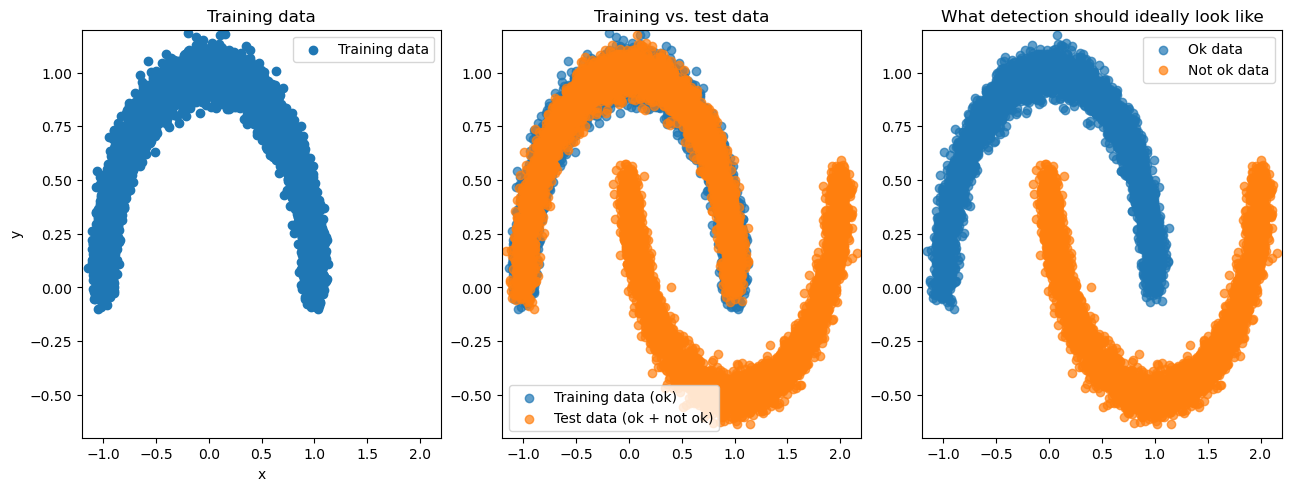

In [28]:
plot_data(X_train, X_test, test_ground_truth)

## Your task

1. Which kind of anomaly detection are you performing?

    1) Supervised
    2) Semi-supervised
    3) Unsupervised

2. Pick a suitable model, for example from scikit-learn (if you know other anomaly detection packages, we're fine with that too)
3. Train it on the training data, and ONLY the training data. Don't cheat by incorporating knowledge about the test set ;-)
4. Try to tell which points of the data are not ok (i.e. don't look like the training data)
5. How good is your model?

## Your solution

Do not hesitate to play around with several different models. Don't worry too much about accuracy - if you're at about 80%, that's fine. We told you the problem is hard ;-) ...

# Problem analysis
We are tackling an unsupervised (we have got labels but they are all the same so they are not useful) anomaly detection problem.



# Model choice
I will implement 3 different models:
- IsolationForest
- KNN 
- simple distance based model
(- Autoencoder model)

# Model training
We will train the model on the training data, and ONLY the training data. 

# Model testing
We will try to tell which points of the data are not ok 

# Model evaluation
We will evaluate the model by looking at the accuracy of the model.


# 1 IsolationForest

In [29]:
from sklearn.ensemble import IsolationForest

classifier = IsolationForest(random_state=0, n_estimators=500, bootstrap=True, max_samples=0.3)
classifier.fit(X_train)

#NOTE: The decision boundary is getting smoother when increasing the number of estimators.

IsolationForest(bootstrap=True, max_samples=0.3, n_estimators=500,
                random_state=0)

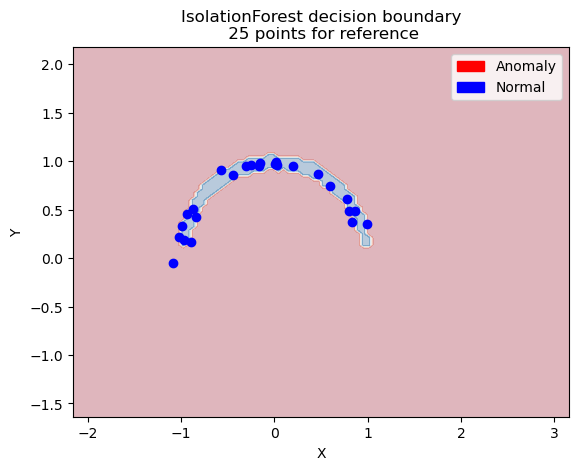

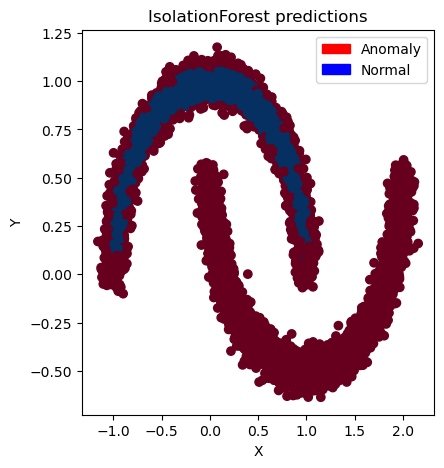

In [30]:
from sklearn.inspection import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(classifier, X_test, response_method="predict", alpha=0.3, cmap="RdBu")
plt.scatter(X_train[:25, 0], X_train[:25, 1], c="blue", label="Training data")
plt.title("IsolationForest decision boundary\n 25 points for reference")
plt.xlabel("X")
plt.ylabel("Y")

# Create a custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Anomaly')
blue_patch = mpatches.Patch(color='blue', label='Normal')
plt.legend(handles=[red_patch, blue_patch])

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=classifier.predict(X_test), cmap="RdBu")
plt.title("IsolationForest predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(handles=[red_patch, blue_patch])

plt.show()




In [31]:
accuracy_score(test_ground_truth, classifier.predict(X_test))

0.8719

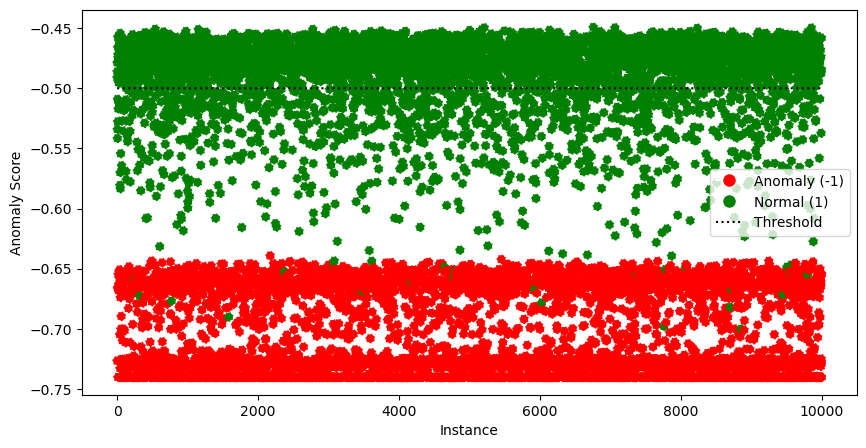

In [32]:
# Visualization of the results
plt.figure(figsize=(10, 5))


# Plot anomalies
classifier_predictions = classifier.score_samples(X_test)


# Create a colormap based on test_ground_truth
colors = ['red' if label == -1 else 'green' for label in test_ground_truth]

# Plot the points with colors based on test_ground_truth
plt.scatter(np.arange(len(classifier_predictions)), classifier_predictions, c=colors, linestyle="dotted")

# Add a legend for the colors
red_dot = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomaly (-1)')
green_dot = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal (1)')
black_line = plt.Line2D([0], [1], color='black', linestyle='dotted', label='Threshold')


plt.legend(handles=[red_dot, green_dot, black_line])
plt.plot(np.arange(len(classifier_predictions)), np.ones(len(classifier_predictions))*classifier.offset_, linestyle="dotted", color="black")

plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.show()

As we can see, the model is not very accurate but still has a good performance of about 87%. All green points are below the threshhold line are classified as anomalies, even though they are normal.

# 2. simple distance based model (computationally expensive)
The second model will simply calculate the distance to the nearest training data point and classify the point as an anomaly if the distance is greater than a certain threshold.
We set the threshhold to the 95th percentile of the distances to the neighbours.

In [33]:
min_dist_list = []
for i, point in enumerate(X_train):
    # Exclude the point itself using np.delete
    other_points = np.delete(X_train, i, axis=0)
    # Compute Euclidean distances from point to every other point
    distances = np.linalg.norm(other_points - point, axis=1)
    min_dist = np.min(distances)
    min_dist_list.append(min_dist)

threshold = np.percentile(min_dist_list, 95)
print("Threshold:", threshold)


Threshold: 0.009859923673417542


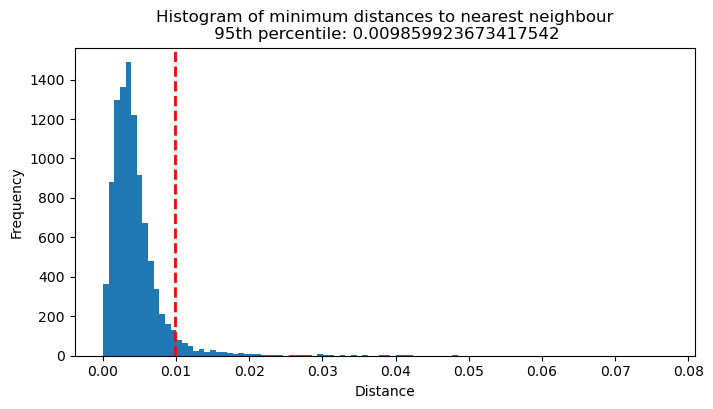

In [34]:
plt.figure(figsize=(8, 4))
plt.hist(min_dist_list, bins=100)
plt.title("Histogram of minimum distances to nearest neighbour\n 95th percentile: " + str(threshold))
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Calculate the 95th percentile
quantile_95 = np.percentile(min_dist_list, 95)


# Draw a vertical line at the 95th percentile
plt.axvline(quantile_95, color='red', linestyle='--', linewidth=2,
            label=f'95th Percentile: {quantile_95:.2f}')


plt.show()



In [35]:
labels = [] 
for point in X_test:
    min_dist = np.min(np.linalg.norm(X_train - point, axis=1))
    if min_dist <= threshold:
        labels.append(1)
    else:
        labels.append(-1)

accuracy_score(test_ground_truth, labels)

0.9718

We did very good with this simple approach. Now i will to try to improve the model by changing the threshhold.

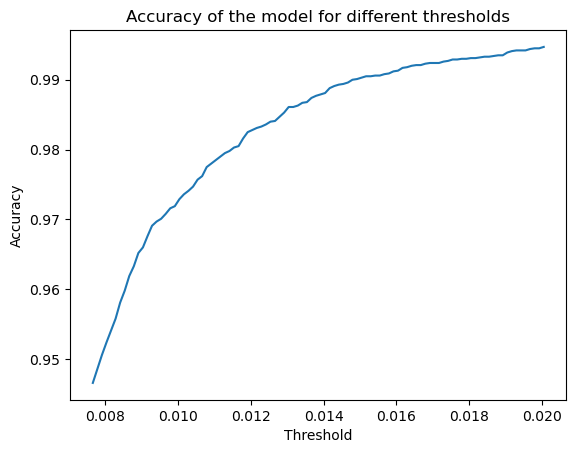

In [36]:
threshhold_list = np.linspace(np.percentile(min_dist_list, 90), np.percentile(min_dist_list, 99), 100)

accuracy_list = []
for threshold in threshhold_list:
    labels = [] 
    for point in X_test:
        min_dist = np.min(np.linalg.norm(X_train - point, axis=1))
        if min_dist <= threshold:
            labels.append(1)
        else:
            labels.append(-1)
    accuracy_list.append(accuracy_score(test_ground_truth, labels))

plt.plot(threshhold_list, accuracy_list)
plt.title("Accuracy of the model for different thresholds")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

As we increase the threshold the accuracy increases. Because we know the distribution of the data, setting the threshhold to the 99,99th percentile hopefully gives us a very good accuracy.
If we didn't know the distribution of the data, one would stick to a threshold of 95th percentile to hopefully detect the anomalies and still have a good accuracy.
Quick reminder: Settint the threshhold higher will result in more false negatives, since more anomalies are classified as normal. Therefore we should not set the threshhold too high (e.g. 2 in our case).


In [37]:
threshold = np.percentile(min_dist_list, 99.99)
labels = [] 
for point in X_test:
    min_dist = np.min(np.linalg.norm(X_train - point, axis=1))
    if min_dist <= threshold:
        labels.append(1)
    else:
        labels.append(-1)

accuracy_score(test_ground_truth, labels)

0.9999

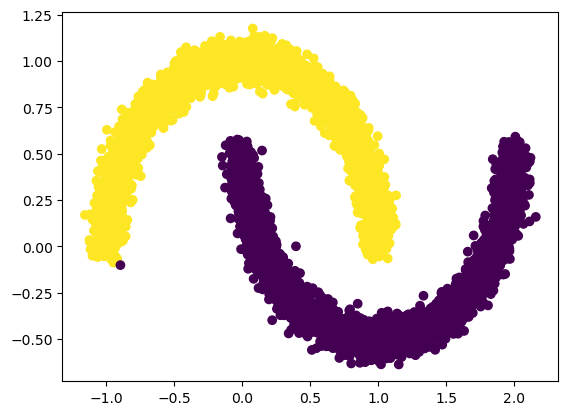

In [38]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels)

# Autoencoder approach
Since the data is 2 dimensional, an autoencoder might not be the best approach, since it can only compress the data to 1 dimension and thereby reducing it only by 1/2.
But we will try it anyway and see how it performs.


In [46]:
import tensorflow as tf
input_dim = 2
first_layer_dim = 5
hidden_dim = 1
second_layer_dim = 5
output_dim = 2

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(first_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(hidden_dim, activation='sigmoid'),
    tf.keras.layers.Dense(second_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(output_dim, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error')

#fit the model only on the training dataset!!!
model.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - loss: 0.7976
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 0.2920
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 0.2424
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.1877
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - loss: 0.1303
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 0.0923
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0725
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 0.0623
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0562
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 0.0528
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 0.0490
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 0.0469
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 0.0450
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.0432
Epoch 15/100
31

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


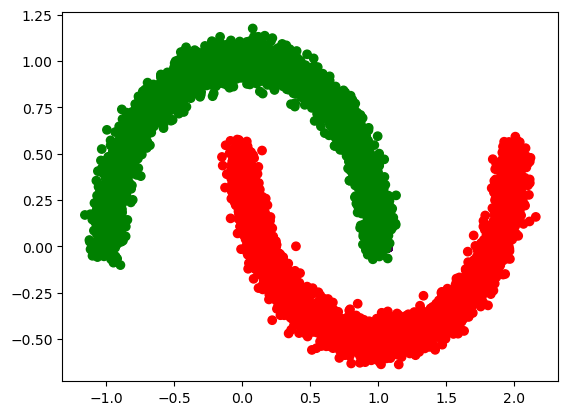

In [56]:
reconstructed_data = model.predict(X_test)

plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], c=test_ground_truth)

predictions = []
for i in range(len(X_test)):
    if np.linalg.norm(X_test[i] - reconstructed_data[i]) > 0.3:
        predictions.append(-1)
    else:
        predictions.append(1)

prediction_colors = ['red' if label == -1 else 'green' for label in predictions]
plt.scatter(X_test[:, 0], X_test[:, 1], c=prediction_colors)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step


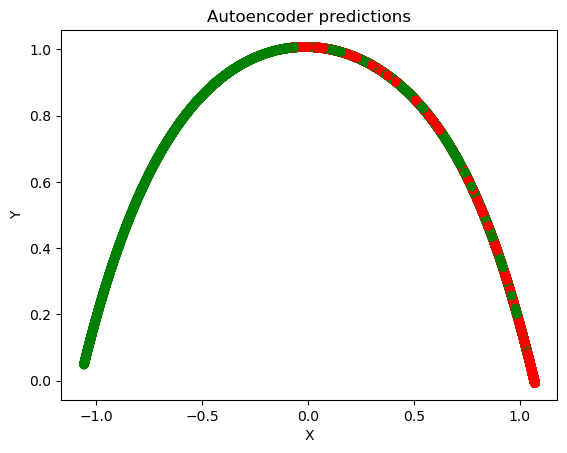

In [57]:
raw_predictions = model.predict(X_test)
colors = ['red' if label == -1 else 'green' for label in test_ground_truth]
plt.scatter(raw_predictions[:, 0], raw_predictions[:, 1], c=colors)
plt.title("Autoencoder predictions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()



In [60]:
accuracy_score(test_ground_truth, predictions)

1.0

The autoencoder is the best model with an accuracy of 100%.
The trick is to first project the data into a higher dimensional space and then project it down to a one dimensional space and then back up again into a higher and finally back to the original space.
If one would do 2 -> 1 -> 2 the model wouldnt be able to adapt to the forms of the data.

# Summary
We have implemented 3 different models and evaluated them. This is the ties list of the models:
1. Autoencoder: 100% accuracy
2. Simple distance based model: 99% accuracy (obviously depending on the selected threshhold)
3. IsolationForest: 87% accuracy

